In [1]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
from models.resnet import resnet50,resnet26,resnet18
from models.vit import VisionTransformer
from models.vgg import vgg16,vgg19
from models.custom_cnn import custom_cnn
from evaluation.predictions import pred_and_plot_image,test_model,plot_confusion_matrix
from data.dataloaders import create_dataloaders, dataloader_vit
from data.transforms import get_vit_eval_transform,get_vit_train_transform,get_train_transforms_paper,get_eval_transforms_paper,get_train_transforms,get_eval_transforms
from training.engine import train
from utils.save_model import save_model
from utils.early_stopping import EarlyStopping
from utils.set_seed import set_seed
from utils.visualisations import plot_acc_loss_curves
from torchinfo import summary

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_WORKERS = os.cpu_count()
EPOCHS = 100

In [4]:
SEED = 42
set_seed(SEED)

## ResNet-50

In [9]:
ResNet50, resnet50_eval_transforms = resnet50(num_classes=10)

In [10]:
resnet50_eval_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [5]:
early_stopper = EarlyStopping(
    patience=15,
    min_delta=0.001
)

In [11]:
#Unbalanced dataset
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet50_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [12]:
optimizer = torch.optim.Adam(params=ResNet50.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [13]:
resnet50_results, best_epoch = train(model=ResNet50,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=100,
                                train_dataloader=train_loader,
                                test_dataloader=val_loader,
                                validation=True,
                                early_stopping=early_stopper)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7350 | train_acc: 0.4060 | val_loss: 1.5544 | val_acc: 0.4637
Epoch: 2 | train_loss: 1.5048 | train_acc: 0.4729 | val_loss: 1.4700 | val_acc: 0.4786
Epoch: 3 | train_loss: 1.4408 | train_acc: 0.4899 | val_loss: 1.4212 | val_acc: 0.5085
Epoch: 4 | train_loss: 1.4162 | train_acc: 0.4977 | val_loss: 1.3952 | val_acc: 0.5092
Epoch: 5 | train_loss: 1.4070 | train_acc: 0.4991 | val_loss: 1.3797 | val_acc: 0.5212
Epoch: 6 | train_loss: 1.3930 | train_acc: 0.5034 | val_loss: 1.3829 | val_acc: 0.5257
Epoch: 7 | train_loss: 1.3834 | train_acc: 0.5108 | val_loss: 1.3615 | val_acc: 0.5199
Epoch: 8 | train_loss: 1.3667 | train_acc: 0.5128 | val_loss: 1.3659 | val_acc: 0.5140
Epoch: 9 | train_loss: 1.3743 | train_acc: 0.5096 | val_loss: 1.3403 | val_acc: 0.5297
Epoch: 10 | train_loss: 1.3592 | train_acc: 0.5149 | val_loss: 1.3469 | val_acc: 0.5285
Epoch: 11 | train_loss: 1.3516 | train_acc: 0.5145 | val_loss: 1.3263 | val_acc: 0.5427
Epoch: 12 | train_loss: 1.3618 | train_ac

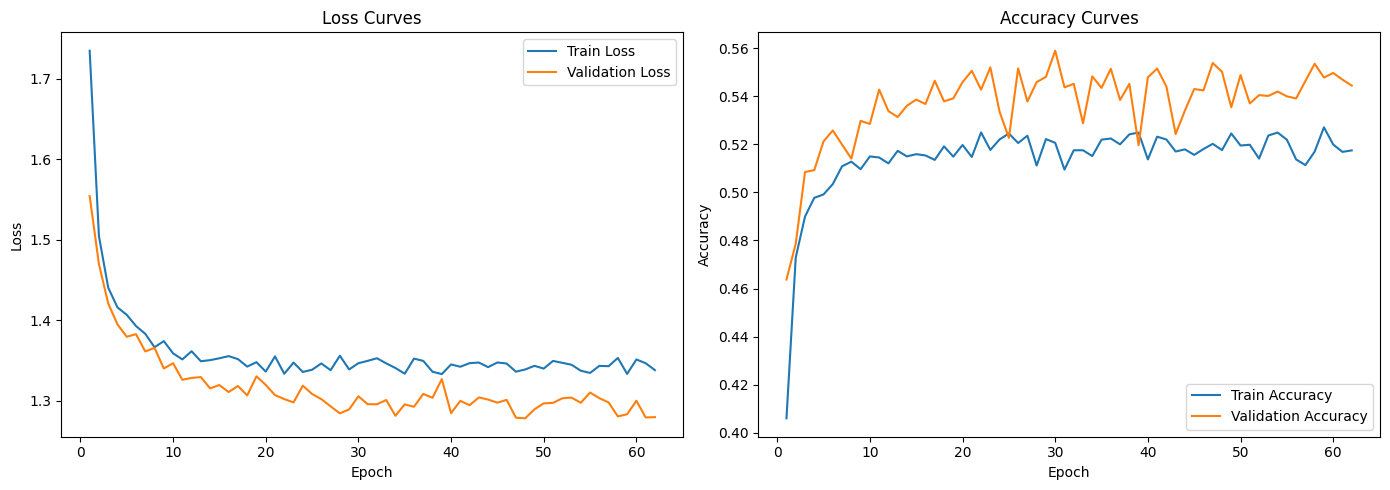

In [14]:
plot_acc_loss_curves(results=resnet50_results,validation=True)

In [15]:
save_model(model=ResNet50,model_name="Resnet50_62_epochs_trainable_classifier_early_stopper.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/resnet50/Resnet50_62_epochs_trainable_classifier_early_stopper.pth


In [16]:
test_results = test_model(model=ResNet50,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5259
Test loss : 1.3268


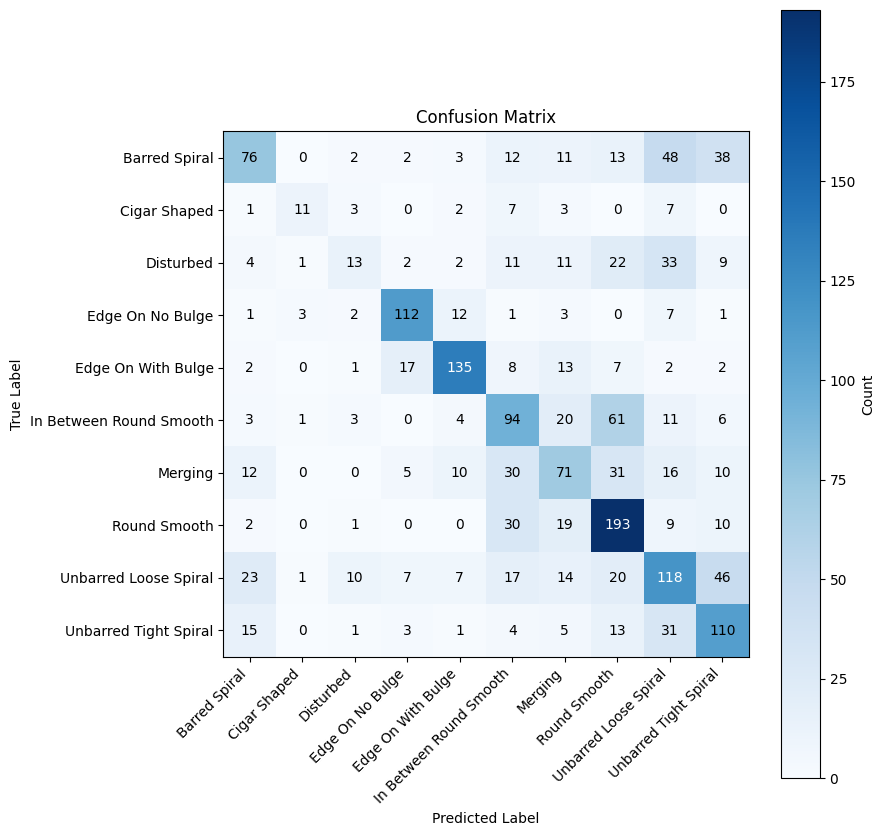

In [17]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>

### Training ResNet50 on balanced dataset

In [32]:
ResNet50, resnet50_eval_transforms = resnet50(num_classes=10)
optimizer = torch.optim.Adam(params=ResNet50.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [33]:
early_stopper = EarlyStopping(
    patience=15,
    min_delta=0.001
)

In [34]:
#Balanced dataset
balanced_train_dir = "../data/Galaxy10_DECaLS_Balanced/train"
balanced_test_dir = "../data/Galaxy10_DECaLS_Balanced/test"

balanced_train_loader, _, balanced_test_loader, class_names= create_dataloaders(train_dir=balanced_train_dir, 
                                                                        test_dir=balanced_test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet50_eval_transforms,
                                                                        batch_size=BATCH_SIZE)


In [35]:
resnet50_results,best_epoch = train(model=ResNet50,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS*3,
                                train_dataloader=balanced_train_loader,
                                test_dataloader=balanced_test_loader,
                                validation=False,
                                early_stopping=early_stopper)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1167 | train_acc: 0.2551 | test_loss: 1.9668 | test_acc: 0.3682
Epoch: 2 | train_loss: 1.8517 | train_acc: 0.3807 | test_loss: 1.8125 | test_acc: 0.3979
Epoch: 3 | train_loss: 1.7331 | train_acc: 0.4126 | test_loss: 1.7560 | test_acc: 0.4187
Epoch: 4 | train_loss: 1.6623 | train_acc: 0.4277 | test_loss: 1.6932 | test_acc: 0.4277
Epoch: 5 | train_loss: 1.6318 | train_acc: 0.4340 | test_loss: 1.6749 | test_acc: 0.4485
Epoch: 6 | train_loss: 1.5948 | train_acc: 0.4375 | test_loss: 1.6381 | test_acc: 0.4625
Epoch: 7 | train_loss: 1.5481 | train_acc: 0.4711 | test_loss: 1.6172 | test_acc: 0.4524
Epoch: 8 | train_loss: 1.5283 | train_acc: 0.4563 | test_loss: 1.5960 | test_acc: 0.4634
Epoch: 9 | train_loss: 1.5252 | train_acc: 0.4674 | test_loss: 1.6024 | test_acc: 0.4640
Epoch: 10 | train_loss: 1.4865 | train_acc: 0.4772 | test_loss: 1.5834 | test_acc: 0.4685
Epoch: 11 | train_loss: 1.4896 | train_acc: 0.4795 | test_loss: 1.5664 | test_acc: 0.4655
Epoch: 12 | train_l

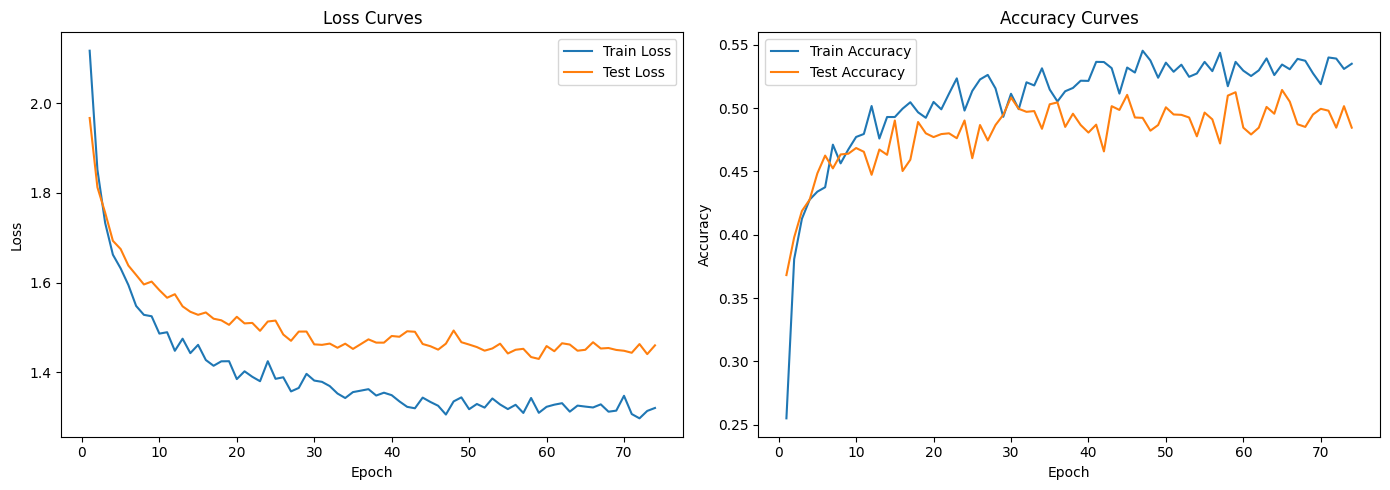

In [36]:
plot_acc_loss_curves(results=resnet50_results,validation=False)

In [39]:
save_model(model=ResNet50,model_name=f"Resnet50_74_epochs_trainable_classifier_early_stopping_balanced_dataset.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/resnet50/Resnet50_74_epochs_trainable_classifier_early_stopping_balanced_dataset.pth


#### Evaluating ResNet50 on balanced test dataset

In [40]:
balanced_test_results = test_model(model=ResNet50,
                       test_dataloader=balanced_test_loader,
                       device=device)

print(f"Test accuracy : {balanced_test_results["test_accuracy"]:.4f}")
print(f"Test loss : {balanced_test_results["test_loss"]:.4f}")

Test accuracy : 0.4833
Test loss : 1.4588


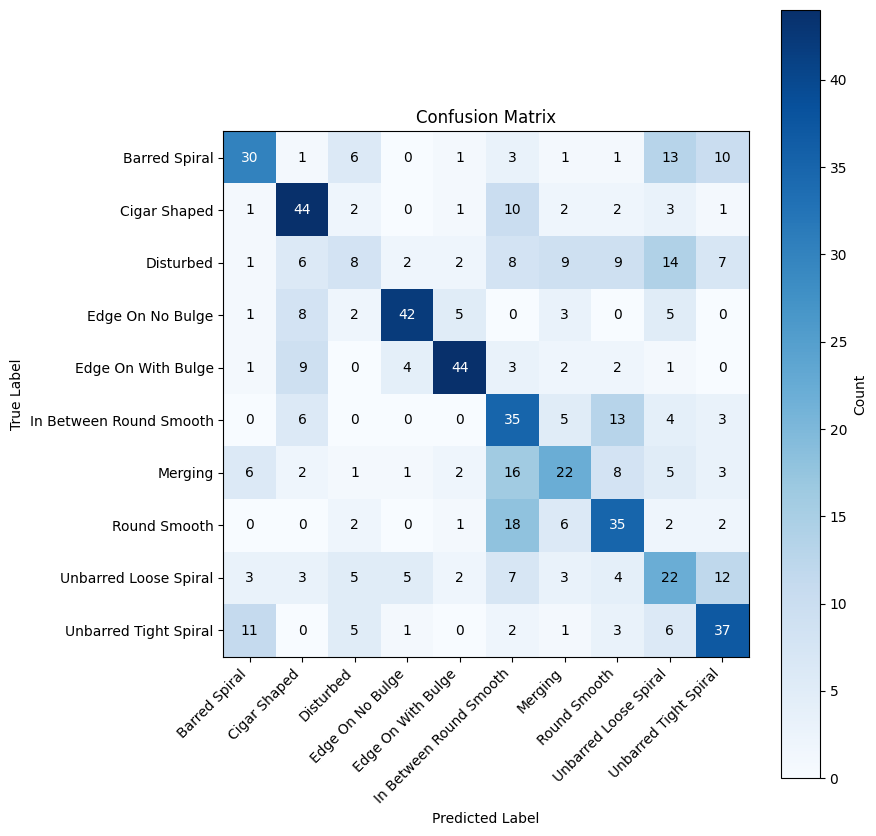

In [41]:
plot_confusion_matrix(labels=balanced_test_results["labels"],
                                  predictions=balanced_test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>

#### Evaluating ResNet50 on unbalanced test dataset

In [42]:
test_results = test_model(model=ResNet50, #Test results on unbalanced test dataset
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.4752
Test loss : 1.4446


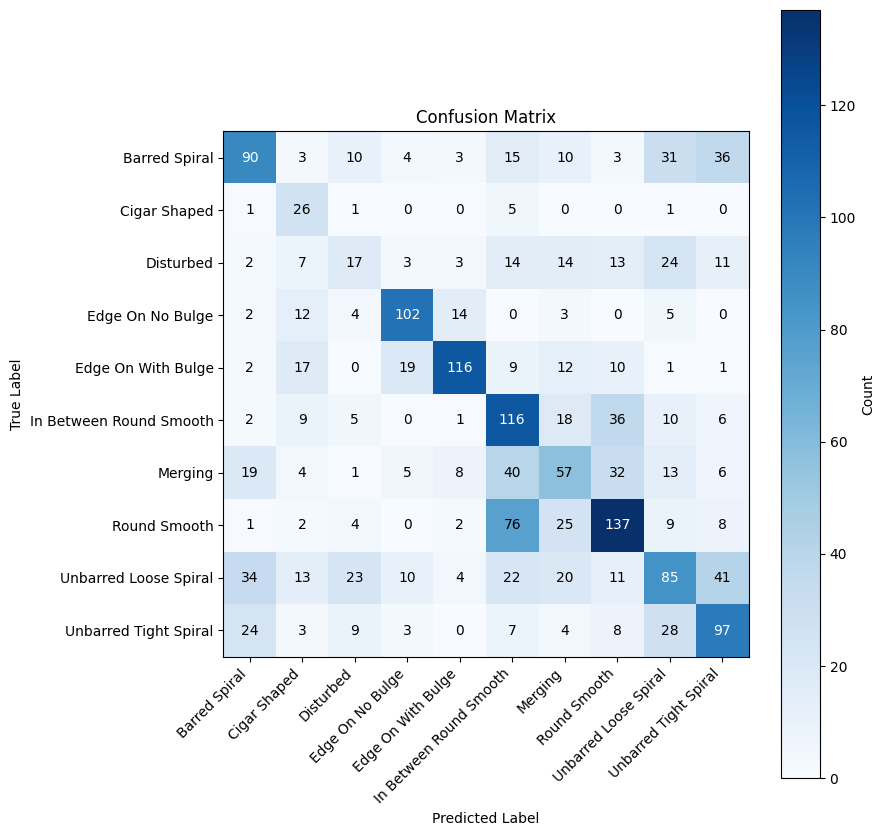

In [43]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>
<br>
<br>

## ResNet-26

In [ ]:
ResNet26, resnet26_eval_transforms = resnet26(num_classes=10)

In [8]:
resnet26_eval_transforms

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [ ]:
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=transforms.get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet26_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [10]:
optimizer = torch.optim.Adam(params=ResNet26.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
resnet26_results = train(model=ResNet26,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS,
                                train_dataloader=train_loader,
                                test_dataloader=val_loader,
                                validation=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5267 | train_acc: 0.4553 | val_loss: 1.4596 | val_acc: 0.4875
Epoch: 2 | train_loss: 1.3545 | train_acc: 0.5132 | val_loss: 1.4349 | val_acc: 0.4984
Epoch: 3 | train_loss: 1.3183 | train_acc: 0.5279 | val_loss: 1.4346 | val_acc: 0.4904
Epoch: 4 | train_loss: 1.3051 | train_acc: 0.5296 | val_loss: 1.4044 | val_acc: 0.5044
Epoch: 5 | train_loss: 1.2998 | train_acc: 0.5339 | val_loss: 1.4178 | val_acc: 0.4880
Epoch: 6 | train_loss: 1.2782 | train_acc: 0.5432 | val_loss: 1.3960 | val_acc: 0.5122
Epoch: 7 | train_loss: 1.2807 | train_acc: 0.5376 | val_loss: 1.3604 | val_acc: 0.5108
Epoch: 8 | train_loss: 1.2716 | train_acc: 0.5403 | val_loss: 1.4576 | val_acc: 0.4724
Epoch: 9 | train_loss: 1.2797 | train_acc: 0.5434 | val_loss: 1.3803 | val_acc: 0.5112
Epoch: 10 | train_loss: 1.2731 | train_acc: 0.5450 | val_loss: 1.3415 | val_acc: 0.5219


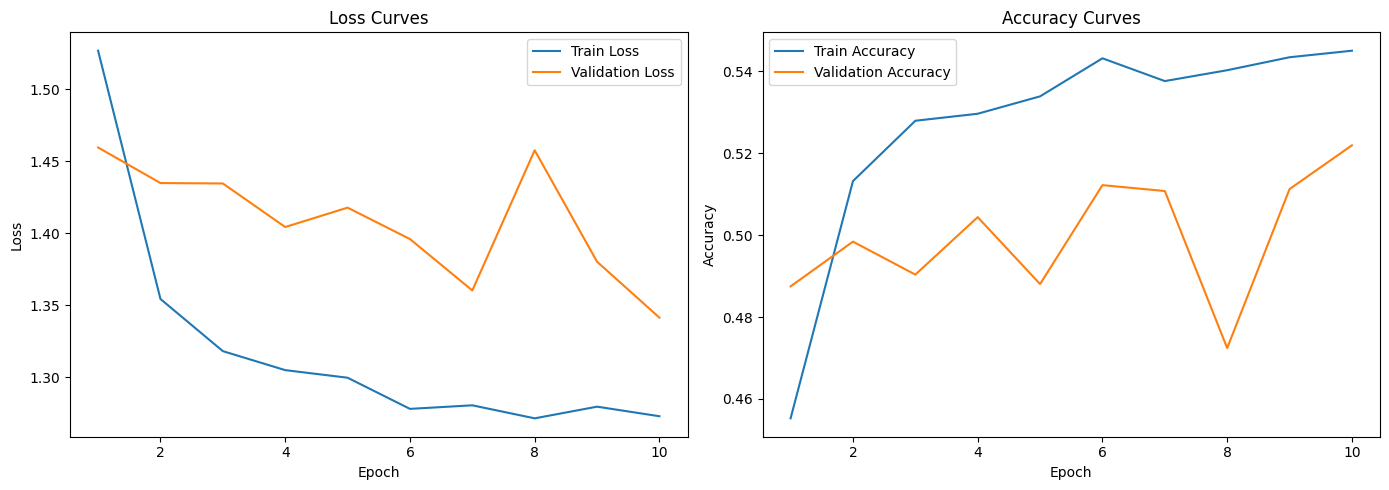

In [ ]:
plot_acc_loss_curves(results=resnet26_results,validation=True)alisations.

In [ ]:
test_results = test_model(model=ResNet26,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5045
Test loss : 1.3673


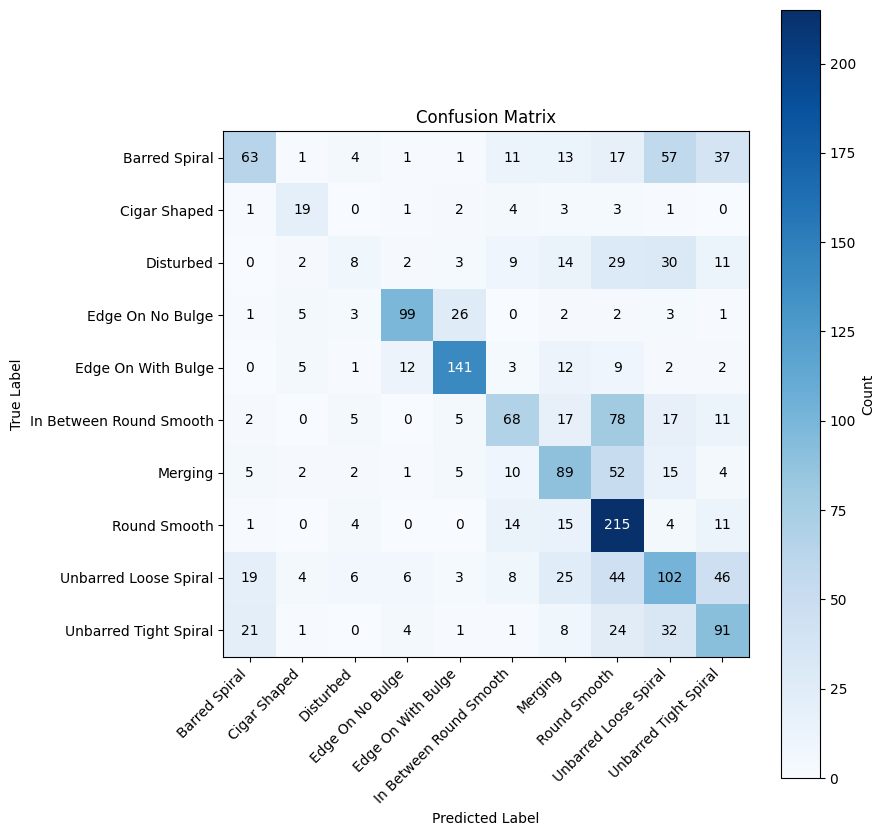

In [ ]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

In [ ]:
save_model(model=ResNet26,model_name="Resnet26_10_epochs_trainable_classifier.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/resnet26/Resnet26_10_epochs_trainable_classifier.pth


### Training ResNet26 on balanced dataset

In [ ]:
ResNet26, resnet26_eval_transforms = resnet26(num_classes=10)
optimizer = torch.optim.Adam(params=ResNet26.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
#Balanced dataset
balanced_train_dir = "../data/Galaxy10_DECaLS_Balanced/train"
balanced_test_dir = "../data/Galaxy10_DECaLS_Balanced/test"
val_dir = "../data/Galaxy10_DECaLS/val" #We're not going to use this in our balanced dataset pipeline

balanced_train_loader, _, balanced_test_loader, class_names= create_dataloaders(train_dir=balanced_train_dir, 
                                                                        test_dir=balanced_test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=transforms.get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet26_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [ ]:
resnet26_results = train(model=ResNet26,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS*3,
                                train_dataloader=balanced_train_loader,
                                test_dataloader=balanced_test_loader,
                                validation=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8877 | train_acc: 0.3402 | test_loss: 1.8772 | test_acc: 0.3253
Epoch: 2 | train_loss: 1.5725 | train_acc: 0.4484 | test_loss: 1.7207 | test_acc: 0.3973
Epoch: 3 | train_loss: 1.4829 | train_acc: 0.4834 | test_loss: 1.6519 | test_acc: 0.3994
Epoch: 4 | train_loss: 1.4096 | train_acc: 0.4932 | test_loss: 1.6256 | test_acc: 0.4238
Epoch: 5 | train_loss: 1.3970 | train_acc: 0.5019 | test_loss: 1.5906 | test_acc: 0.4652
Epoch: 6 | train_loss: 1.3706 | train_acc: 0.5095 | test_loss: 1.5519 | test_acc: 0.4747
Epoch: 7 | train_loss: 1.3481 | train_acc: 0.5236 | test_loss: 1.5299 | test_acc: 0.4792
Epoch: 8 | train_loss: 1.3059 | train_acc: 0.5371 | test_loss: 1.5422 | test_acc: 0.4625
Epoch: 9 | train_loss: 1.2982 | train_acc: 0.5368 | test_loss: 1.5537 | test_acc: 0.4693
Epoch: 10 | train_loss: 1.2936 | train_acc: 0.5427 | test_loss: 1.5349 | test_acc: 0.4533
Epoch: 11 | train_loss: 1.2787 | train_acc: 0.5451 | test_loss: 1.5545 | test_acc: 0.4530
Epoch: 12 | train_l

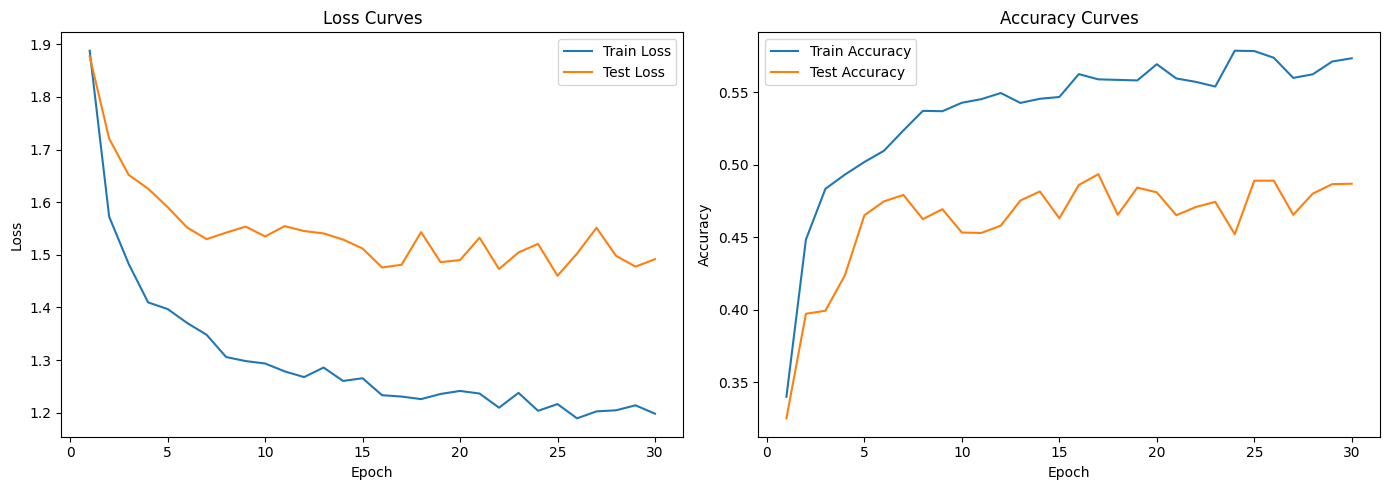

In [ ]:
plot_acc_loss_curves(results=resnet26_results,validation=False)

In [ ]:
save_model(model=ResNet26,model_name="Resnet26_30_epochs_trainable_classifier_balanced_dataset.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/resnet26/Resnet26_30_epochs_trainable_classifier_balanced_dataset.pth


#### Evaluating ResNet26 on balanced test daataset

In [ ]:
balanced_test_results = test_model(model=ResNet26,
                       test_dataloader=balanced_test_loader,
                       device=device)

print(f"Test accuracy : {balanced_test_results["test_accuracy"]:.4f}")
print(f"Test loss : {balanced_test_results["test_loss"]:.4f}")

Test accuracy : 0.4894
Test loss : 1.4860


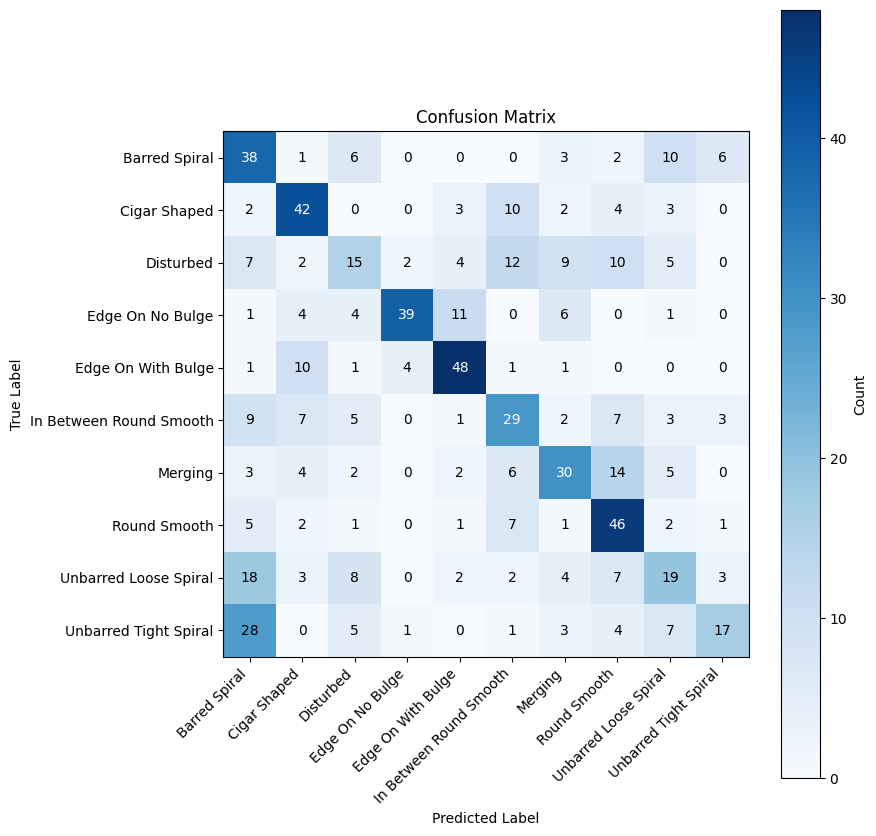

In [ ]:
plot_confusion_matrix(labels=balanced_test_results["labels"],
                                  predictions=balanced_test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>

#### Evaluating ResNet26 on unbalanced test daataset

In [ ]:
test_results = test_model(model=ResNet26,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5096
Test loss : 1.3619


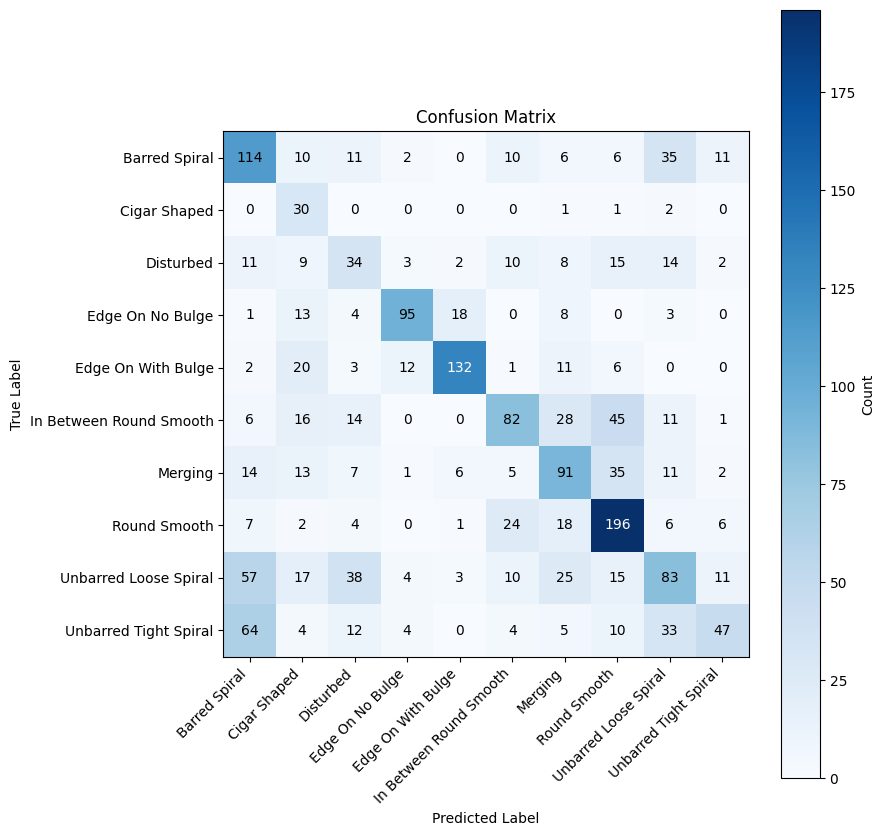

In [ ]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)
#Confusion matrix for unbalanced test dataset

<br>
<br>
<br>

## ResNet18

In [5]:
ResNet18, resnet18_eval_transforms = resnet18(num_classes=10)

In [6]:
resnet18_eval_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [7]:
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet18_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [8]:
optimizer = torch.optim.Adam(params=ResNet18.parameters(),lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

In [9]:
resnet18_results = train(model=ResNet18,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      device=device,
                      epochs=EPOCHS*3,
                      train_dataloader=train_loader,
                      test_dataloader=val_loader,
                      validation=True)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7303 | train_acc: 0.3806 | val_loss: 1.6039 | val_acc: 0.4279
Epoch: 2 | train_loss: 1.5164 | train_acc: 0.4552 | val_loss: 1.5395 | val_acc: 0.4675
Epoch: 3 | train_loss: 1.4793 | train_acc: 0.4672 | val_loss: 1.4914 | val_acc: 0.4854
Epoch: 4 | train_loss: 1.4600 | train_acc: 0.4734 | val_loss: 1.4695 | val_acc: 0.4766
Epoch: 5 | train_loss: 1.4562 | train_acc: 0.4736 | val_loss: 1.4864 | val_acc: 0.4743
Epoch: 6 | train_loss: 1.4438 | train_acc: 0.4830 | val_loss: 1.4324 | val_acc: 0.4753
Epoch: 7 | train_loss: 1.4459 | train_acc: 0.4786 | val_loss: 1.4590 | val_acc: 0.4841
Epoch: 8 | train_loss: 1.4404 | train_acc: 0.4898 | val_loss: 1.4328 | val_acc: 0.4916
Epoch: 9 | train_loss: 1.4224 | train_acc: 0.4905 | val_loss: 1.4627 | val_acc: 0.4859
Epoch: 10 | train_loss: 1.4343 | train_acc: 0.4785 | val_loss: 1.4722 | val_acc: 0.4640
Epoch: 11 | train_loss: 1.4321 | train_acc: 0.4864 | val_loss: 1.4255 | val_acc: 0.4983
Epoch: 12 | train_loss: 1.4268 | train_ac

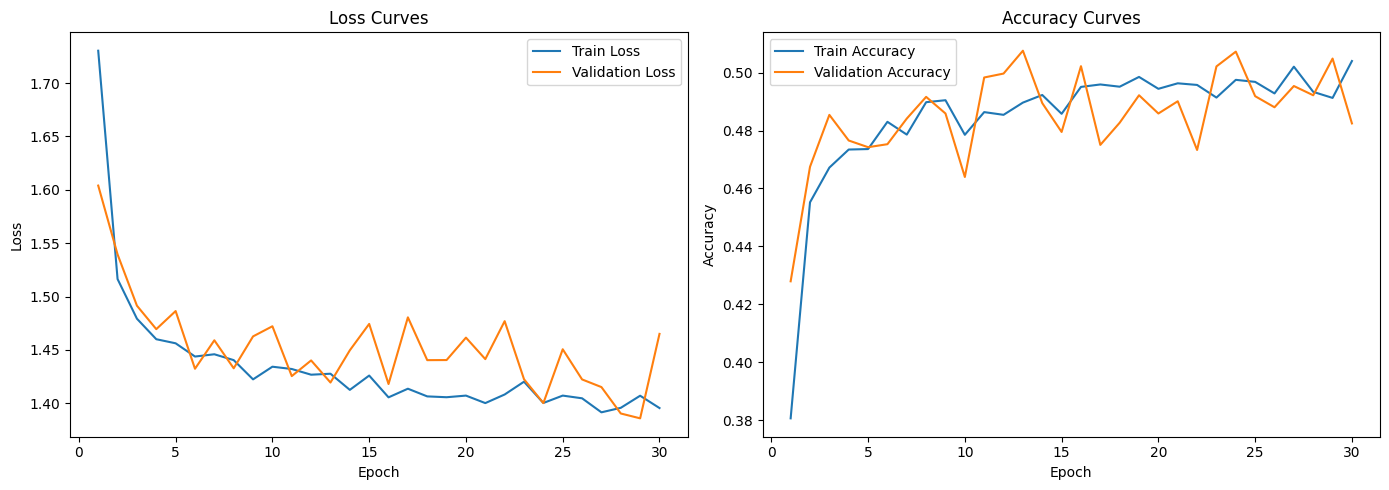

In [10]:
plot_acc_loss_curves(results=resnet18_results,validation=True)

In [12]:
test_results = test_model(model=ResNet18,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.4572
Test loss : 1.5182


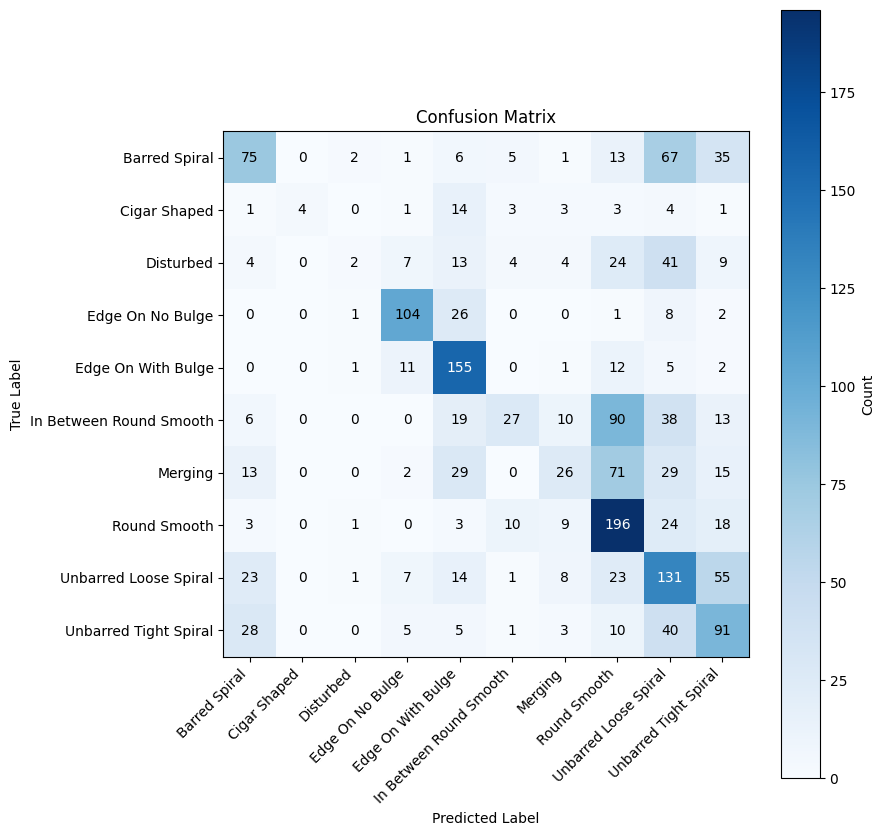

In [13]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

In [11]:
save_model(model=ResNet18,model_name="Resnet18_30_epochs_trainable_classifier.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/resnet18/Resnet18_30_epochs_trainable_classifier.pth


<br>

### Training ResNet18 on balanced dataset

In [14]:
ResNet18, resnet18_eval_transforms = resnet18(num_classes=10)
optimizer = torch.optim.Adam(params=ResNet18.parameters(),lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

In [15]:
#Balanced dataset
balanced_train_dir = "../data/Galaxy10_DECaLS_Balanced/train"
balanced_test_dir = "../data/Galaxy10_DECaLS_Balanced/test"
val_dir = "../data/Galaxy10_DECaLS/val" #We're not going to use this in our balanced dataset pipeline

balanced_train_loader, _, balanced_test_loader, class_names= create_dataloaders(train_dir=balanced_train_dir, 
                                                                        test_dir=balanced_test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet18_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [16]:
resnet18_results = train(model=ResNet18,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      device=device,
                      epochs=EPOCHS*3,
                      train_dataloader=balanced_train_loader,
                      test_dataloader=balanced_test_loader,
                      validation=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0782 | train_acc: 0.2495 | test_loss: 1.9025 | test_acc: 0.3268
Epoch: 2 | train_loss: 1.7767 | train_acc: 0.3792 | test_loss: 1.7590 | test_acc: 0.3976
Epoch: 3 | train_loss: 1.6799 | train_acc: 0.4043 | test_loss: 1.7164 | test_acc: 0.3815
Epoch: 4 | train_loss: 1.6061 | train_acc: 0.4218 | test_loss: 1.6932 | test_acc: 0.3872
Epoch: 5 | train_loss: 1.6042 | train_acc: 0.4235 | test_loss: 1.6844 | test_acc: 0.3902
Epoch: 6 | train_loss: 1.5453 | train_acc: 0.4463 | test_loss: 1.5934 | test_acc: 0.4339
Epoch: 7 | train_loss: 1.5635 | train_acc: 0.4494 | test_loss: 1.6498 | test_acc: 0.3946
Epoch: 8 | train_loss: 1.5528 | train_acc: 0.4370 | test_loss: 1.6007 | test_acc: 0.4369
Epoch: 9 | train_loss: 1.4960 | train_acc: 0.4685 | test_loss: 1.5933 | test_acc: 0.4244
Epoch: 10 | train_loss: 1.5070 | train_acc: 0.4597 | test_loss: 1.6227 | test_acc: 0.4199
Epoch: 11 | train_loss: 1.4992 | train_acc: 0.4552 | test_loss: 1.5739 | test_acc: 0.4402
Epoch: 12 | train_l

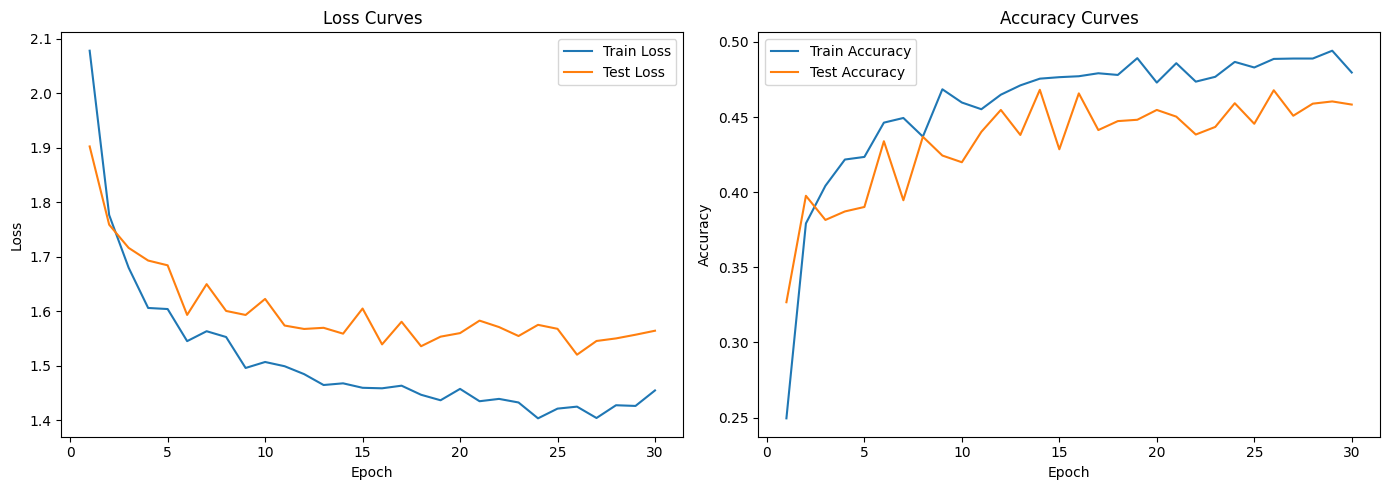

In [17]:
plot_acc_loss_curves(results=resnet18_results,validation=False)

In [18]:
save_model(model=ResNet18,model_name="Resnet18_30_epochs_trainable_classifier_balanced_dataset.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/resnet18/Resnet18_30_epochs_trainable_classifier_balanced_dataset.pth


<br>

#### Evaluating ResNet18 (trained on balanced dataset) on balanced test dataset

In [19]:
balanced_test_results = test_model(model=ResNet18,
                       test_dataloader=balanced_test_loader,
                       device=device)

print(f"Test accuracy : {balanced_test_results["test_accuracy"]:.4f}")
print(f"Test loss : {balanced_test_results["test_loss"]:.4f}")

Test accuracy : 0.4621
Test loss : 1.5507


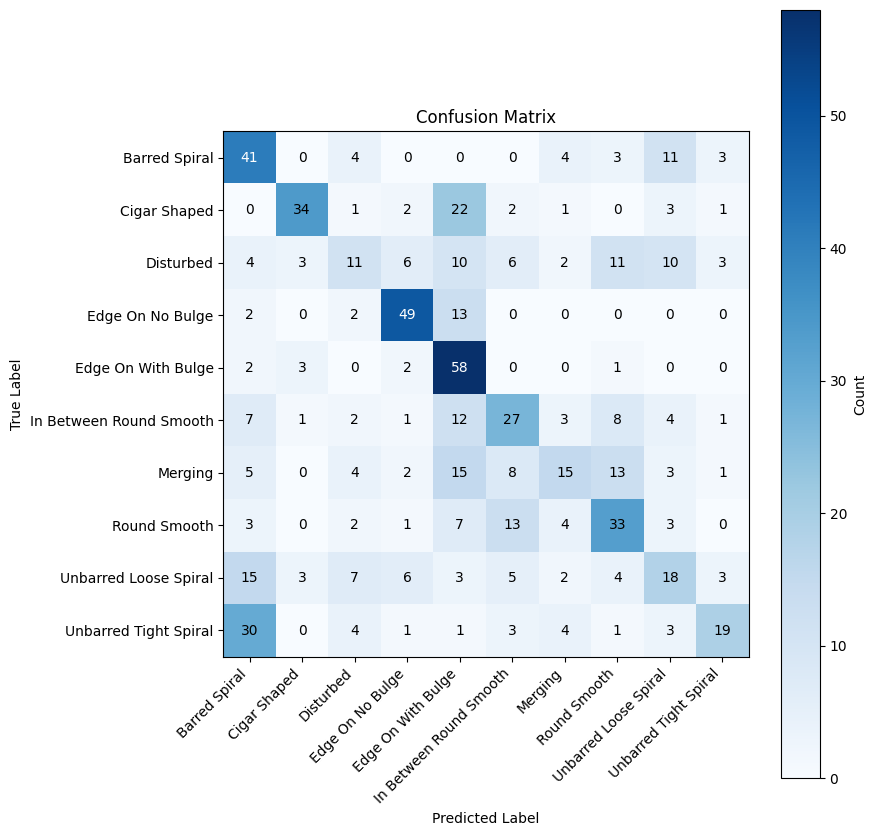

In [20]:
plot_confusion_matrix(labels=balanced_test_results["labels"],
                                  predictions=balanced_test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>

#### Evaluating ResNet18 (trained on balanced dataset) on unbalanced test dataset

In [21]:
test_results = test_model(model=ResNet18,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.4425
Test loss : 1.5545


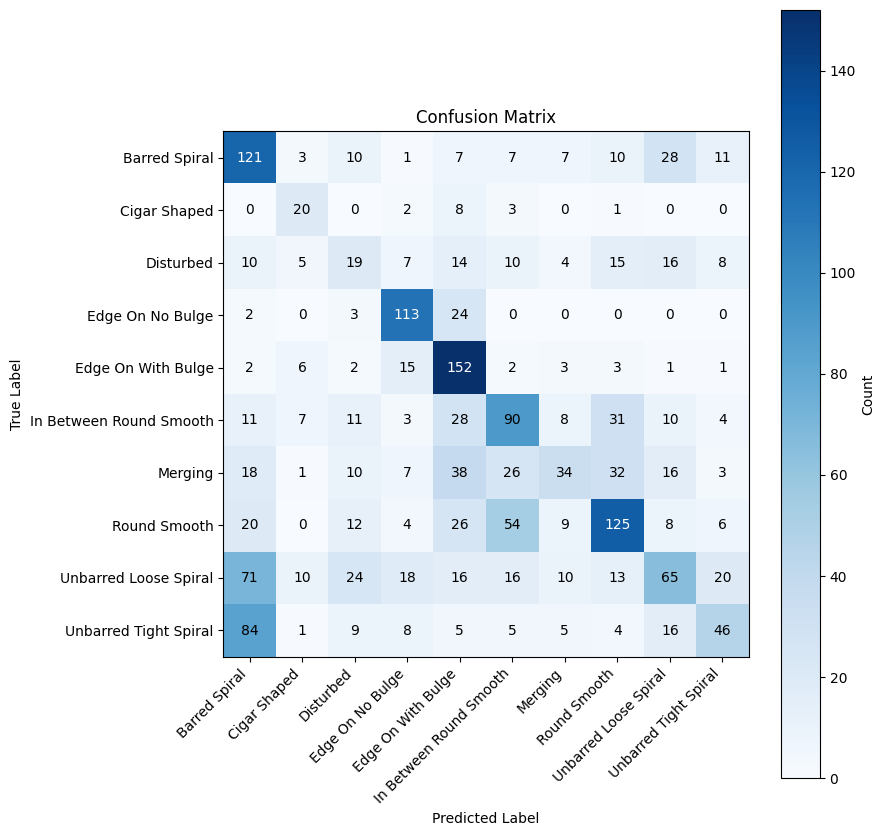

In [22]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>
<br>
<br>

## VGG16

In [ ]:
Vgg16, vgg16_eval_transforms = vgg16(num_classes=10)

In [7]:
vgg16_eval_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=transforms.get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=vgg16_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [18]:
optimizer = torch.optim.Adam(params=Vgg16.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
vgg16_results = train(model=Vgg16,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS,
                                train_dataloader=train_loader,
                                test_dataloader=val_loader,
                                validation=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6784 | train_acc: 0.3971 | val_loss: 1.3670 | val_acc: 0.4939
Epoch: 2 | train_loss: 1.4209 | train_acc: 0.4797 | val_loss: 1.3032 | val_acc: 0.5396
Epoch: 3 | train_loss: 1.3395 | train_acc: 0.5109 | val_loss: 1.2196 | val_acc: 0.5604
Epoch: 4 | train_loss: 1.3040 | train_acc: 0.5278 | val_loss: 1.3327 | val_acc: 0.5124
Epoch: 5 | train_loss: 1.2747 | train_acc: 0.5384 | val_loss: 1.1658 | val_acc: 0.6004
Epoch: 6 | train_loss: 1.2616 | train_acc: 0.5471 | val_loss: 1.1867 | val_acc: 0.5891
Epoch: 7 | train_loss: 1.2376 | train_acc: 0.5558 | val_loss: 1.1994 | val_acc: 0.5902
Epoch: 8 | train_loss: 1.2208 | train_acc: 0.5581 | val_loss: 1.1809 | val_acc: 0.5835
Epoch: 9 | train_loss: 1.2230 | train_acc: 0.5573 | val_loss: 1.1579 | val_acc: 0.5922
Epoch: 10 | train_loss: 1.2085 | train_acc: 0.5688 | val_loss: 1.1933 | val_acc: 0.5796


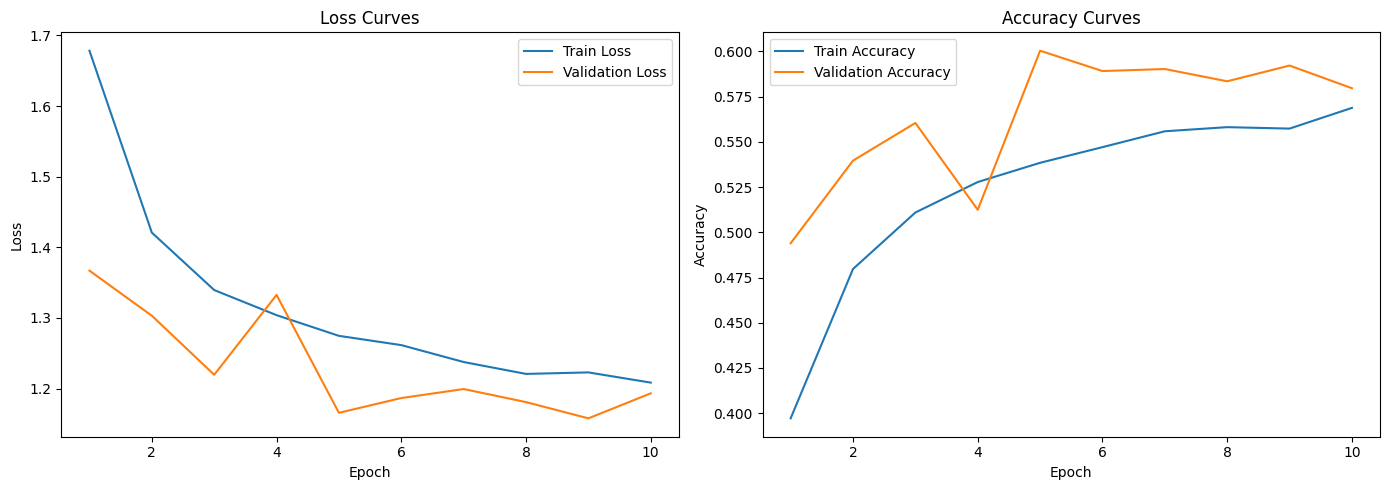

In [ ]:
plot_acc_loss_curves(results=vgg16_results,validation=True)

In [ ]:
test_results = test_model(model=Vgg16,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5547
Test loss : 1.2131


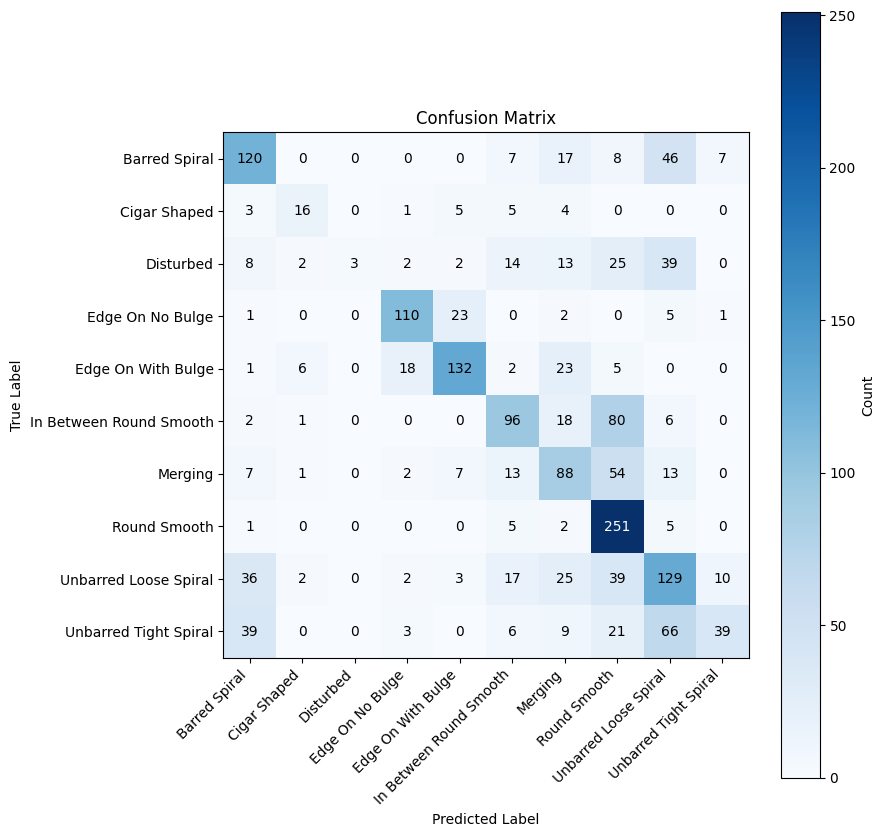

In [ ]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

In [ ]:
save_model(model=ResNet26,model_name="VGG16_10_epochs_trainable_classifier.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/vgg16/VGG16_10_epochs_trainable_classifier.pth


<br>

### Training VGG16 on balanced dataset

In [ ]:
Vgg16, vgg16_eval_transforms = vgg16(num_classes=10)
optimizer = torch.optim.Adam(params=Vgg16.parameters(),lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
#Balanced dataset
balanced_train_dir = "../data/Galaxy10_DECaLS_Balanced/train"
balanced_test_dir = "../data/Galaxy10_DECaLS_Balanced/test"
val_dir = "../data/Galaxy10_DECaLS/val" #We're not going to use this in our balanced dataset pipeline

balanced_train_loader, _, balanced_test_loader, class_names= create_dataloaders(train_dir=balanced_train_dir, 
                                                                        test_dir=balanced_test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=transforms.get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=vgg16_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [ ]:
vgg16_results = train(model=Vgg16,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS*3,
                                train_dataloader=balanced_train_loader,
                                test_dataloader=balanced_test_loader,
                                validation=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2298 | train_acc: 0.2753 | test_loss: 1.6632 | test_acc: 0.3699
Epoch: 2 | train_loss: 1.6409 | train_acc: 0.3728 | test_loss: 1.6306 | test_acc: 0.3839
Epoch: 3 | train_loss: 1.5123 | train_acc: 0.4190 | test_loss: 1.4930 | test_acc: 0.4420
Epoch: 4 | train_loss: 1.4833 | train_acc: 0.4338 | test_loss: 1.4444 | test_acc: 0.4458
Epoch: 5 | train_loss: 1.4796 | train_acc: 0.4514 | test_loss: 1.4647 | test_acc: 0.4640
Epoch: 6 | train_loss: 1.4064 | train_acc: 0.4753 | test_loss: 1.4330 | test_acc: 0.4631
Epoch: 7 | train_loss: 1.3895 | train_acc: 0.4813 | test_loss: 1.3706 | test_acc: 0.5173
Epoch: 8 | train_loss: 1.3489 | train_acc: 0.4990 | test_loss: 1.4076 | test_acc: 0.4938
Epoch: 9 | train_loss: 1.3072 | train_acc: 0.5154 | test_loss: 1.3603 | test_acc: 0.5051
Epoch: 10 | train_loss: 1.2884 | train_acc: 0.5355 | test_loss: 1.2880 | test_acc: 0.5226
Epoch: 11 | train_loss: 1.2634 | train_acc: 0.5448 | test_loss: 1.3425 | test_acc: 0.5030
Epoch: 12 | train_l

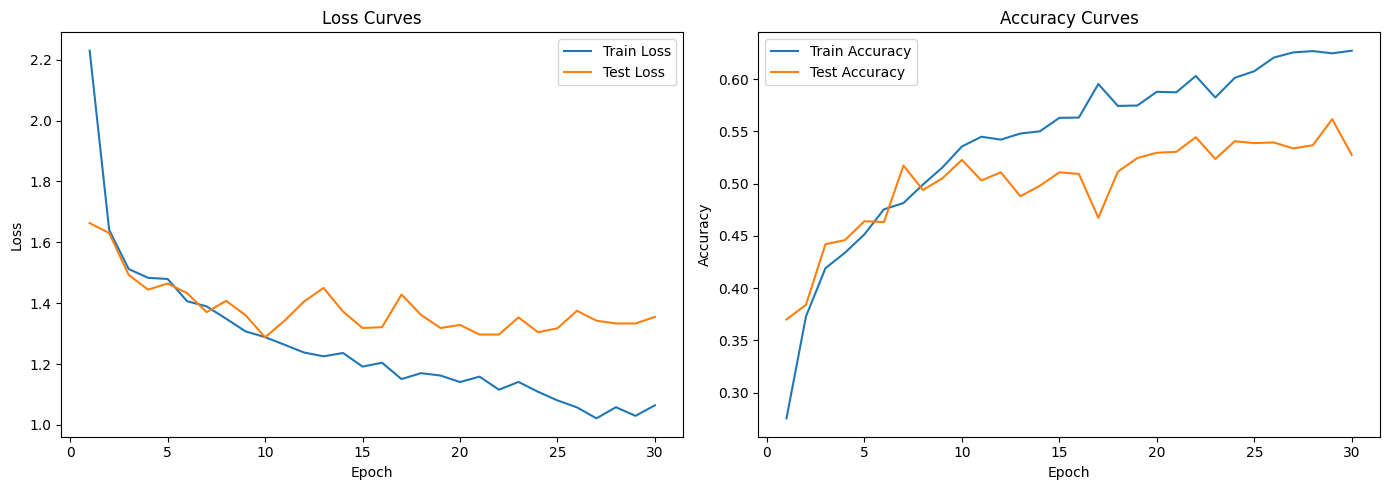

In [ ]:
plot_acc_loss_curves(results=vgg16_results,validation=False)

In [ ]:
save_model(model=Vgg16,model_name="VGG16_30_epochs_trainable_classifier_balanced_dataset.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/vgg16/VGG16_30_epochs_trainable_classifier_balanced_dataset.pth


<br>

#### Evaluating VGG16 on balanced test dataset

In [ ]:
balanced_test_results = test_model(model=Vgg16,
                       test_dataloader=balanced_test_loader,
                       device=device)

print(f"Test accuracy : {balanced_test_results["test_accuracy"]:.4f}")
print(f"Test loss : {balanced_test_results["test_loss"]:.4f}")

Test accuracy : 0.5288
Test loss : 1.3539


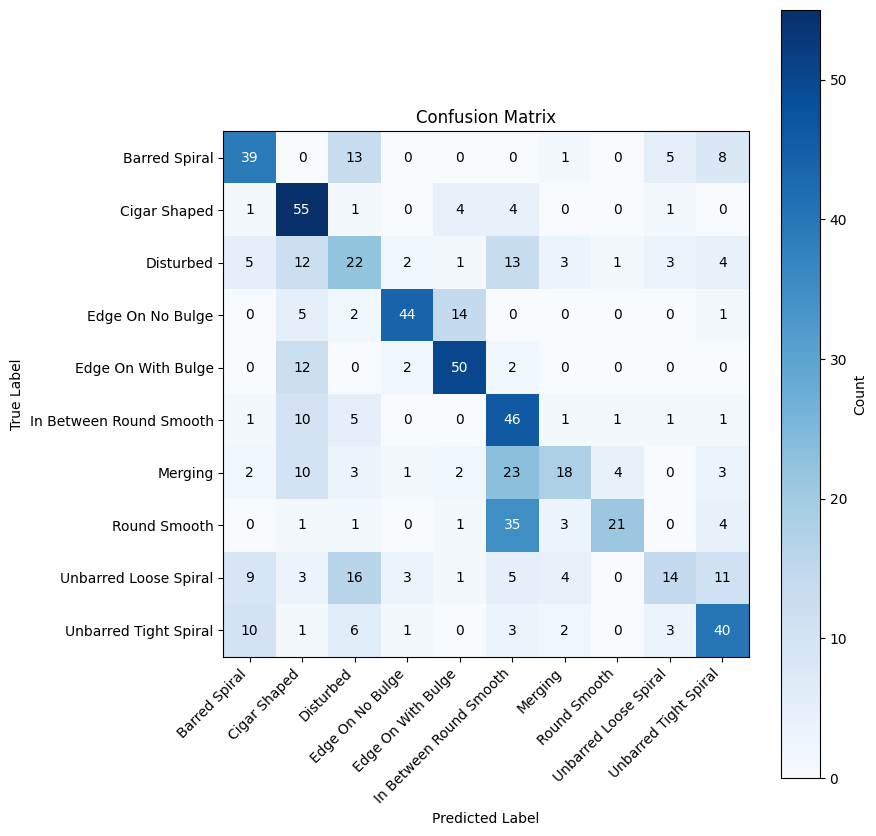

In [ ]:
plot_confusion_matrix(labels=balanced_test_results["labels"],
                                  predictions=balanced_test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

#### Evaluating VGG16 on unbalanced test dataset

In [ ]:
test_results = test_model(model=Vgg16,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5006
Test loss : 1.4262


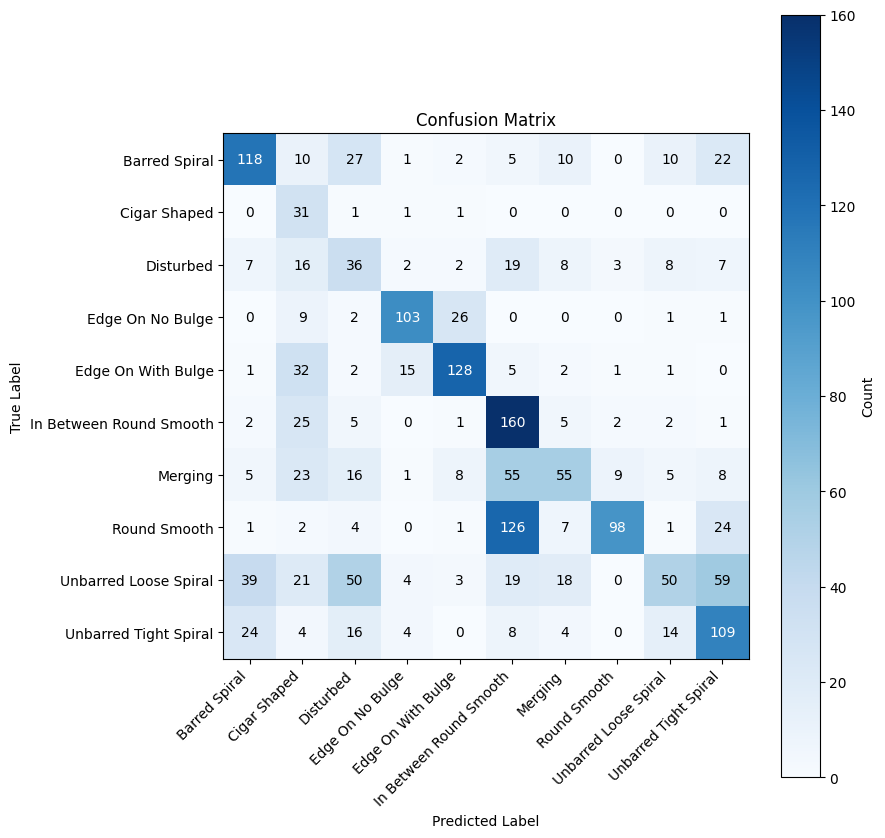

In [ ]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>
<br>
<br>

## VGG19

In [ ]:
Vgg19, vgg19_eval_transforms = vgg19(num_classes=10)

In [25]:
vgg19_eval_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=transforms.get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=vgg19_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [28]:
optimizer = torch.optim.Adam(params=Vgg19.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
vgg19_results = train(model=Vgg19,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS,
                                train_dataloader=train_loader,
                                test_dataloader=val_loader,
                                validation=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8981 | train_acc: 0.3655 | val_loss: 1.4012 | val_acc: 0.4743
Epoch: 2 | train_loss: 1.5443 | train_acc: 0.4228 | val_loss: 1.3097 | val_acc: 0.5231
Epoch: 3 | train_loss: 1.5067 | train_acc: 0.4335 | val_loss: 1.3083 | val_acc: 0.5257
Epoch: 4 | train_loss: 1.4833 | train_acc: 0.4464 | val_loss: 1.2871 | val_acc: 0.5326
Epoch: 5 | train_loss: 1.4611 | train_acc: 0.4549 | val_loss: 1.2883 | val_acc: 0.5177
Epoch: 6 | train_loss: 1.4509 | train_acc: 0.4672 | val_loss: 1.3012 | val_acc: 0.5208
Epoch: 7 | train_loss: 1.4252 | train_acc: 0.4727 | val_loss: 1.2391 | val_acc: 0.5379
Epoch: 8 | train_loss: 1.4193 | train_acc: 0.4778 | val_loss: 1.2845 | val_acc: 0.5277
Epoch: 9 | train_loss: 1.4099 | train_acc: 0.4852 | val_loss: 1.1972 | val_acc: 0.5638
Epoch: 10 | train_loss: 1.4015 | train_acc: 0.4843 | val_loss: 1.2386 | val_acc: 0.5590


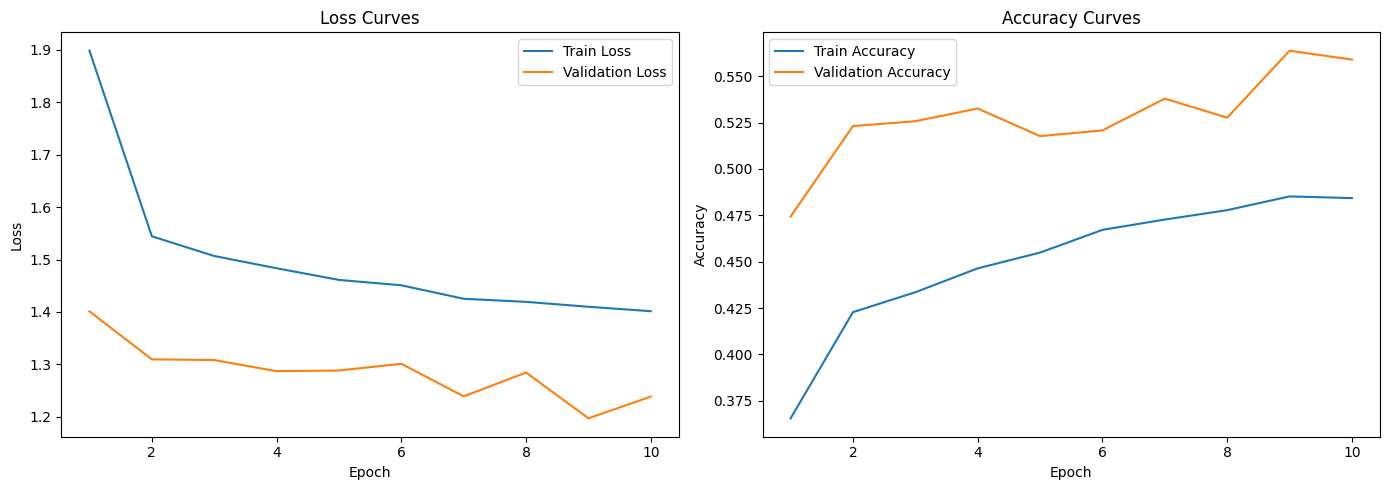

In [ ]:
plot_acc_loss_curves(results=vgg19_results,validation=True)

In [ ]:
test_results = test_model(model=Vgg19,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5299
Test loss : 1.2985


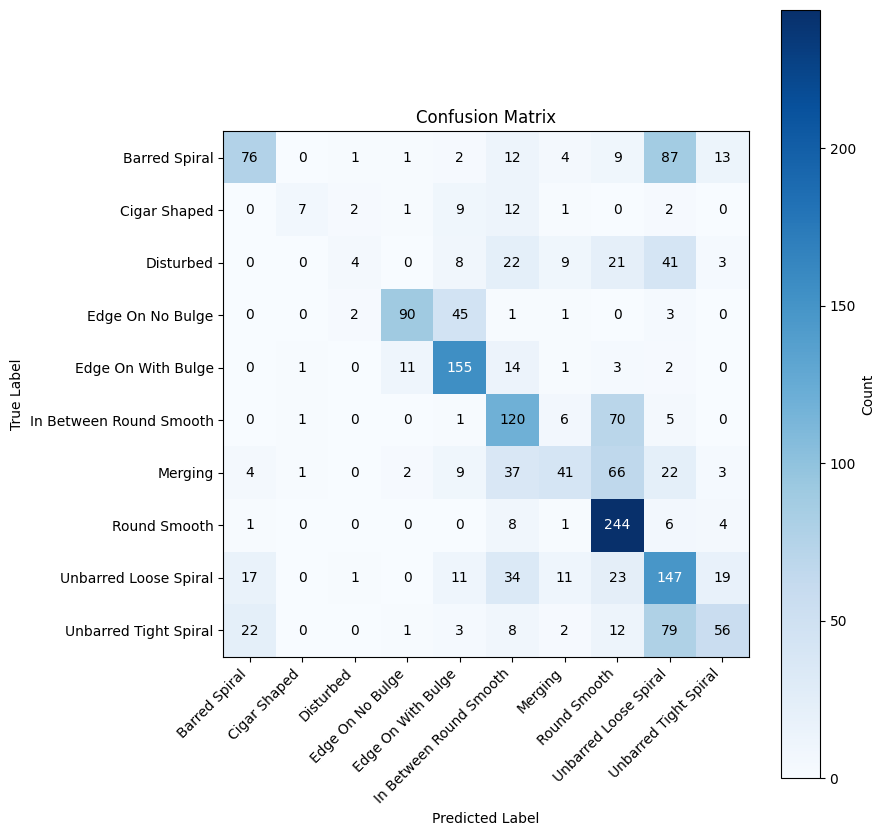

In [ ]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

In [ ]:
save_model(model=ResNet26,model_name="VGG19_10_epochs_trainable_classifier.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/vgg19/VGG19_10_epochs_trainable_classifier.pth


<br>

#### Training VGG19 on balanced dataset

In [ ]:
Vgg19, vgg19_eval_transforms = vgg19(num_classes=10)
optimizer = torch.optim.Adam(params=Vgg19.parameters(),lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
#Balanced dataset
balanced_train_dir = "../data/Galaxy10_DECaLS_Balanced/train"
balanced_test_dir = "../data/Galaxy10_DECaLS_Balanced/test"
val_dir = "../data/Galaxy10_DECaLS/val" #We're not going to use this in our balanced dataset pipeline

balanced_train_loader, _, balanced_test_loader, class_names= create_dataloaders(train_dir=balanced_train_dir, 
                                                                        test_dir=balanced_test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=transforms.get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=vgg19_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [ ]:
vgg19_results = train(model=Vgg19,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS*3,
                                train_dataloader=balanced_train_loader,
                                test_dataloader=balanced_test_loader,
                                validation=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.0894 | train_acc: 0.2732 | test_loss: 1.6828 | test_acc: 0.4146
Epoch: 2 | train_loss: 1.6991 | train_acc: 0.3548 | test_loss: 1.5403 | test_acc: 0.4199
Epoch: 3 | train_loss: 1.6155 | train_acc: 0.3910 | test_loss: 1.4928 | test_acc: 0.4476
Epoch: 4 | train_loss: 1.5963 | train_acc: 0.3991 | test_loss: 1.4399 | test_acc: 0.4643
Epoch: 5 | train_loss: 1.5829 | train_acc: 0.3973 | test_loss: 1.4460 | test_acc: 0.4643
Epoch: 6 | train_loss: 1.5703 | train_acc: 0.4053 | test_loss: 1.5033 | test_acc: 0.4494
Epoch: 7 | train_loss: 1.5591 | train_acc: 0.4146 | test_loss: 1.4458 | test_acc: 0.4711
Epoch: 8 | train_loss: 1.4931 | train_acc: 0.4410 | test_loss: 1.4469 | test_acc: 0.4860
Epoch: 9 | train_loss: 1.5067 | train_acc: 0.4292 | test_loss: 1.5440 | test_acc: 0.4446
Epoch: 10 | train_loss: 1.4632 | train_acc: 0.4597 | test_loss: 1.5168 | test_acc: 0.4616
Epoch: 11 | train_loss: 1.4726 | train_acc: 0.4567 | test_loss: 1.4537 | test_acc: 0.4824
Epoch: 12 | train_l

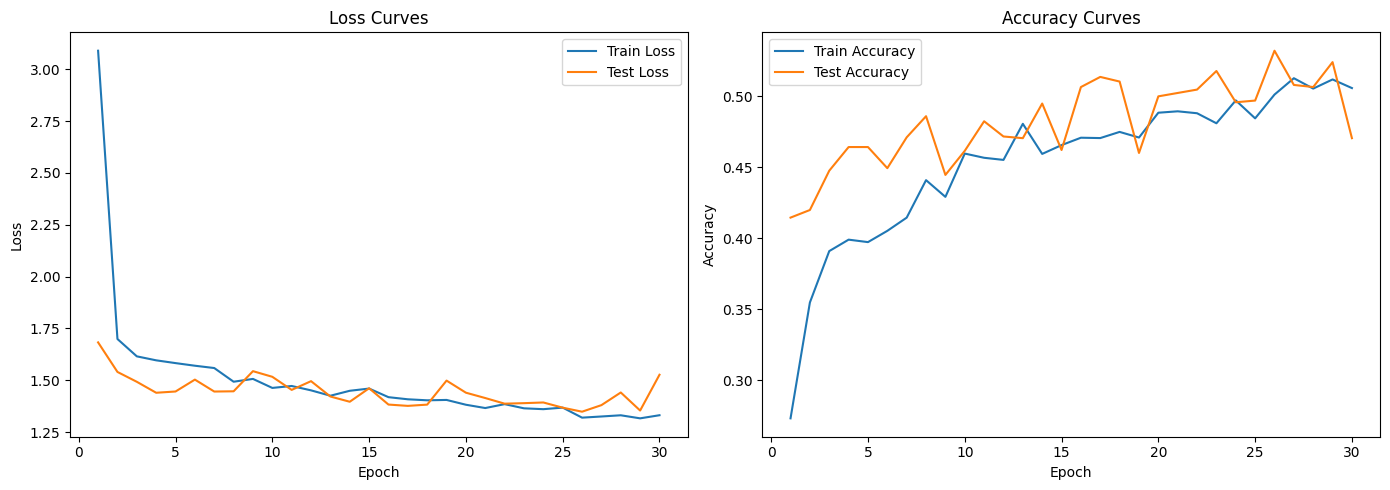

In [ ]:
plot_acc_loss_curves(results=vgg19_results,validation=False)

<br>

#### Evaluating VGG19 on balanced test dataset

In [ ]:
balanced_test_results = test_model(model=Vgg19,
                       test_dataloader=balanced_test_loader,
                       device=device)

print(f"Test accuracy : {balanced_test_results["test_accuracy"]:.4f}")
print(f"Test loss : {balanced_test_results["test_loss"]:.4f}")

Test accuracy : 0.4773
Test loss : 1.5104


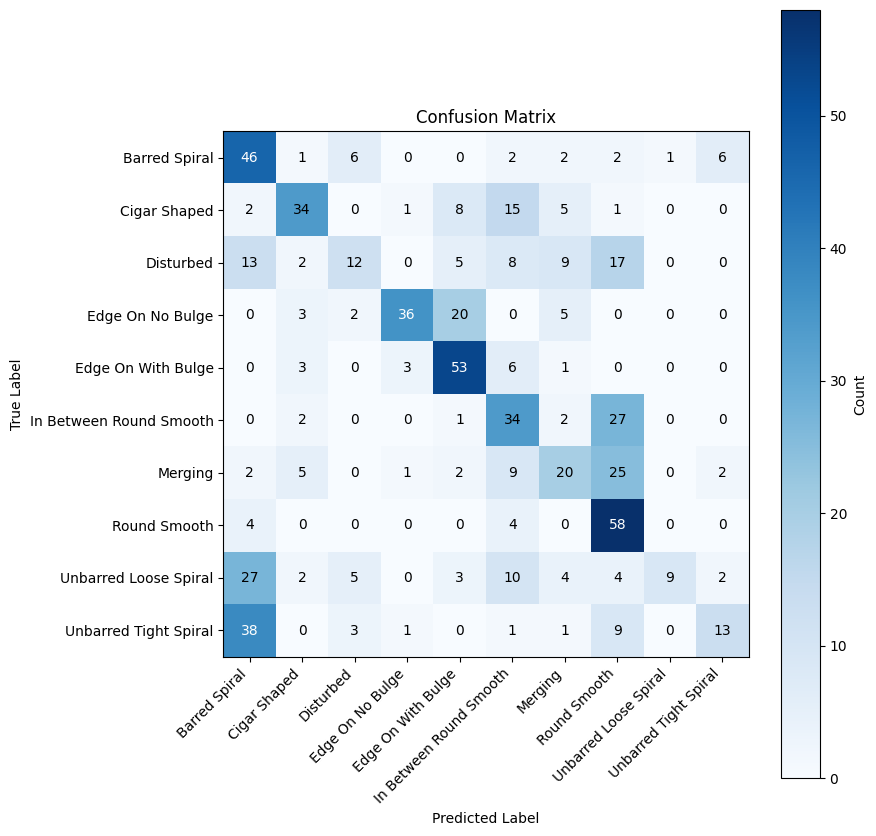

In [ ]:
plot_confusion_matrix(labels=balanced_test_results["labels"],
                                  predictions=balanced_test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

#### Evaluating VGG19 on balanced test dataset

In [ ]:
est_results = test_model(model=Vgg19,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5006
Test loss : 1.4262


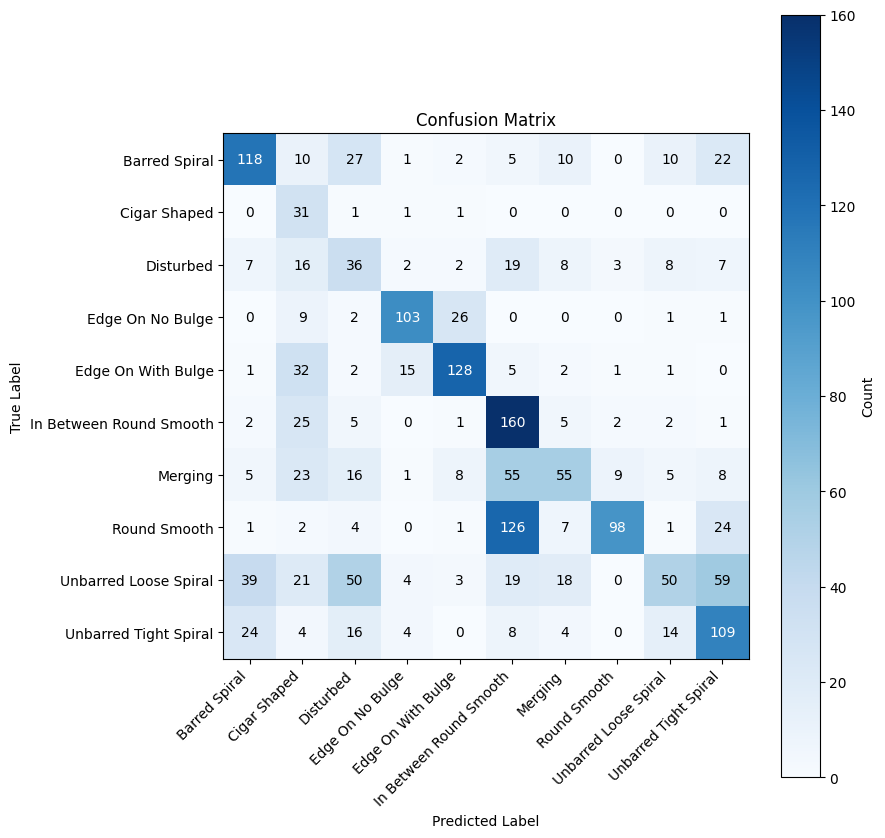

In [ ]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>
<br>
<br>

## Custom CNN

In [ ]:
custom_model = custom_cnn(num_classes=10).to(device)

I trained the custom model for around 48 epochs since the returns were diminshing with every extra epoch

In [9]:
from torchinfo import summary

summary(
    custom_model,
    input_size=(1, 3, 224, 224)
)

Layer (type:depth-idx)                   Output Shape              Param #
CustomCNN                                [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 5, 5]             --
│    └─Conv2d: 2-1                       [1, 512, 222, 222]        14,336
│    └─ReLU: 2-2                         [1, 512, 222, 222]        --
│    └─MaxPool2d: 2-3                    [1, 512, 111, 111]        --
│    └─Conv2d: 2-4                       [1, 256, 109, 109]        1,179,904
│    └─ReLU: 2-5                         [1, 256, 109, 109]        --
│    └─MaxPool2d: 2-6                    [1, 256, 54, 54]          --
│    └─Conv2d: 2-7                       [1, 128, 52, 52]          295,040
│    └─ReLU: 2-8                         [1, 128, 52, 52]          --
│    └─MaxPool2d: 2-9                    [1, 128, 26, 26]          --
│    └─Conv2d: 2-10                      [1, 128, 24, 24]          147,584
│    └─ReLU: 2-11                        [1, 128, 24, 24]       

In [ ]:
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=transforms.get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=transforms.get_eval_transforms(resize_size=256,crop_size=224),
                                                                        batch_size=16)

In [11]:
optimizer = torch.optim.Adam(params=custom_model.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
custom_model_results = train(model=custom_model,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS*3,
                                train_dataloader=train_loader,
                                test_dataloader=val_loader,
                                validation=True)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6843 | train_acc: 0.3536 | val_loss: 1.4703 | val_acc: 0.4310
Epoch: 2 | train_loss: 1.4393 | train_acc: 0.4619 | val_loss: 1.3022 | val_acc: 0.5279
Epoch: 3 | train_loss: 1.2971 | train_acc: 0.5305 | val_loss: 1.1449 | val_acc: 0.5850
Epoch: 4 | train_loss: 1.2035 | train_acc: 0.5602 | val_loss: 1.1239 | val_acc: 0.6056
Epoch: 5 | train_loss: 1.1350 | train_acc: 0.5900 | val_loss: 1.0091 | val_acc: 0.6406
Epoch: 6 | train_loss: 1.0726 | train_acc: 0.6170 | val_loss: 0.9835 | val_acc: 0.6552
Epoch: 7 | train_loss: 1.0272 | train_acc: 0.6386 | val_loss: 0.9404 | val_acc: 0.6614
Epoch: 8 | train_loss: 0.9871 | train_acc: 0.6543 | val_loss: 0.9583 | val_acc: 0.6754
Epoch: 9 | train_loss: 0.9556 | train_acc: 0.6688 | val_loss: 0.9479 | val_acc: 0.6815
Epoch: 10 | train_loss: 0.9288 | train_acc: 0.6798 | val_loss: 0.9501 | val_acc: 0.6879
Epoch: 11 | train_loss: 0.8938 | train_acc: 0.6915 | val_loss: 0.8048 | val_acc: 0.7314
Epoch: 12 | train_loss: 0.8772 | train_ac

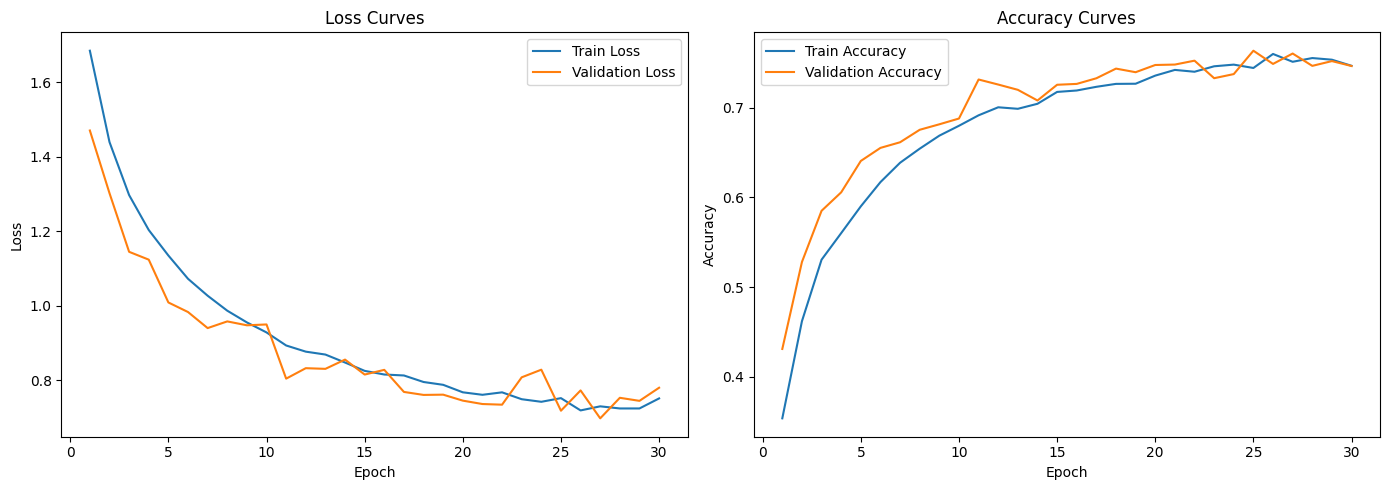

In [ ]:
plot_acc_loss_curves(results=custom_model_results,validation=True)

In [15]:
save_model.save_model(model=custom_model,model_name="CustomCNN_30_epochs.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/custom_cnn/CustomCNN_30_epochs.pth


In [ ]:
test_results = test_model(model=custom_model,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.7520
Test loss : 0.7757


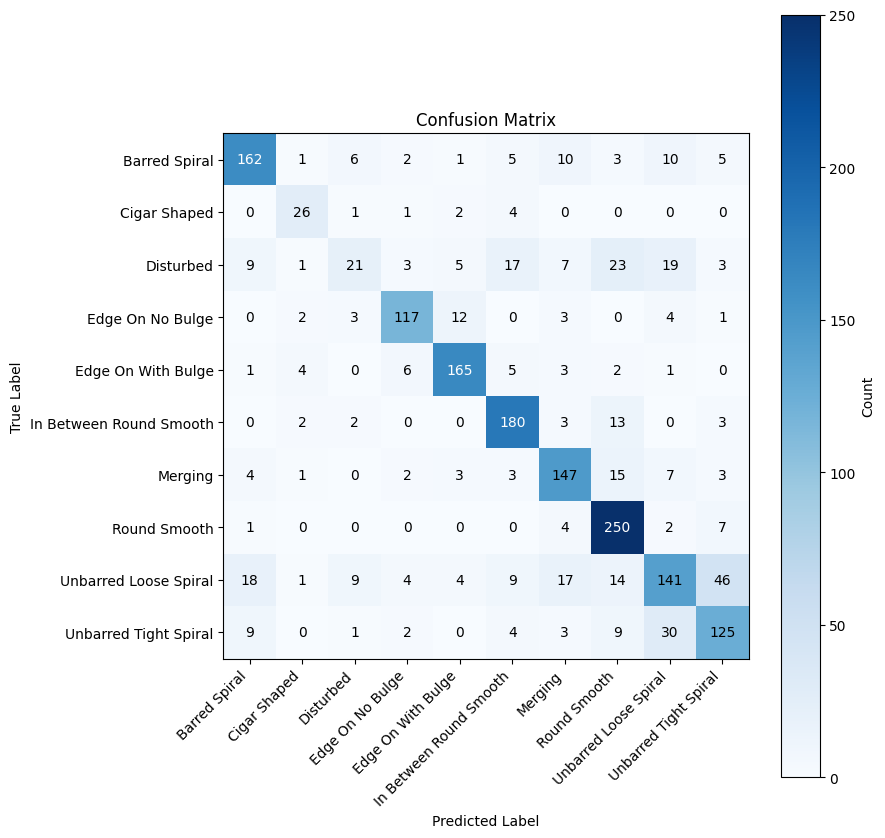

In [ ]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>

#### Training Custom CNN on balanced dataset

In [5]:
custom_model = custom_cnn.custom_cnn(num_classes=10).to(device)
optimizer = torch.optim.Adam(params=custom_model.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss().to(device=device)

In [ ]:
#Balanced dataset
balanced_train_dir = "../data/Galaxy10_DECaLS_Balanced/train"
balanced_test_dir = "../data/Galaxy10_DECaLS_Balanced/test"
val_dir = "../data/Galaxy10_DECaLS/val" #We're not going to use this in our balanced dataset pipeline

balanced_train_loader, _, balanced_test_loader, class_names= create_dataloaders(train_dir=balanced_train_dir, 
                                                                        test_dir=balanced_test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=transforms.get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=transforms.get_eval_transforms(resize_size=256,crop_size=224),
                                                                        batch_size=16)

In [ ]:
custom_model_results = train(model=custom_model,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS*3,
                                train_dataloader=balanced_train_loader,
                                test_dataloader=balanced_test_loader,
                                validation=False)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1931 | train_acc: 0.1551 | test_loss: 2.0370 | test_acc: 0.2321
Epoch: 2 | train_loss: 1.9389 | train_acc: 0.2567 | test_loss: 1.8657 | test_acc: 0.3006
Epoch: 3 | train_loss: 1.8329 | train_acc: 0.2898 | test_loss: 1.8812 | test_acc: 0.2857
Epoch: 4 | train_loss: 1.7987 | train_acc: 0.2872 | test_loss: 1.8023 | test_acc: 0.3006
Epoch: 5 | train_loss: 1.7336 | train_acc: 0.3207 | test_loss: 1.7584 | test_acc: 0.3125
Epoch: 6 | train_loss: 1.6516 | train_acc: 0.3705 | test_loss: 1.6588 | test_acc: 0.3601
Epoch: 7 | train_loss: 1.5898 | train_acc: 0.3813 | test_loss: 1.4879 | test_acc: 0.4449
Epoch: 8 | train_loss: 1.5384 | train_acc: 0.4107 | test_loss: 1.5739 | test_acc: 0.3973
Epoch: 9 | train_loss: 1.4824 | train_acc: 0.4364 | test_loss: 1.5060 | test_acc: 0.4420
Epoch: 10 | train_loss: 1.4159 | train_acc: 0.4628 | test_loss: 1.4030 | test_acc: 0.4583
Epoch: 11 | train_loss: 1.3919 | train_acc: 0.4732 | test_loss: 1.4667 | test_acc: 0.4702
Epoch: 12 | train_l

In [8]:
save_model.save_model(model=custom_model,model_name="CustomCNN_30_epochs_balanced_dataset.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/custom_cnn/CustomCNN_30_epochs_balanced_dataset.pth


<br>

#### Evaluating on balanced test dataset

In [ ]:
balanced_test_results = test_model(model=custom_model,
                       test_dataloader=balanced_test_loader,
                       device=device)

print(f"Test accuracy : {balanced_test_results["test_accuracy"]:.4f}")
print(f"Test loss : {balanced_test_results["test_loss"]:.4f}")

Test accuracy : 0.5758
Test loss : 1.2259


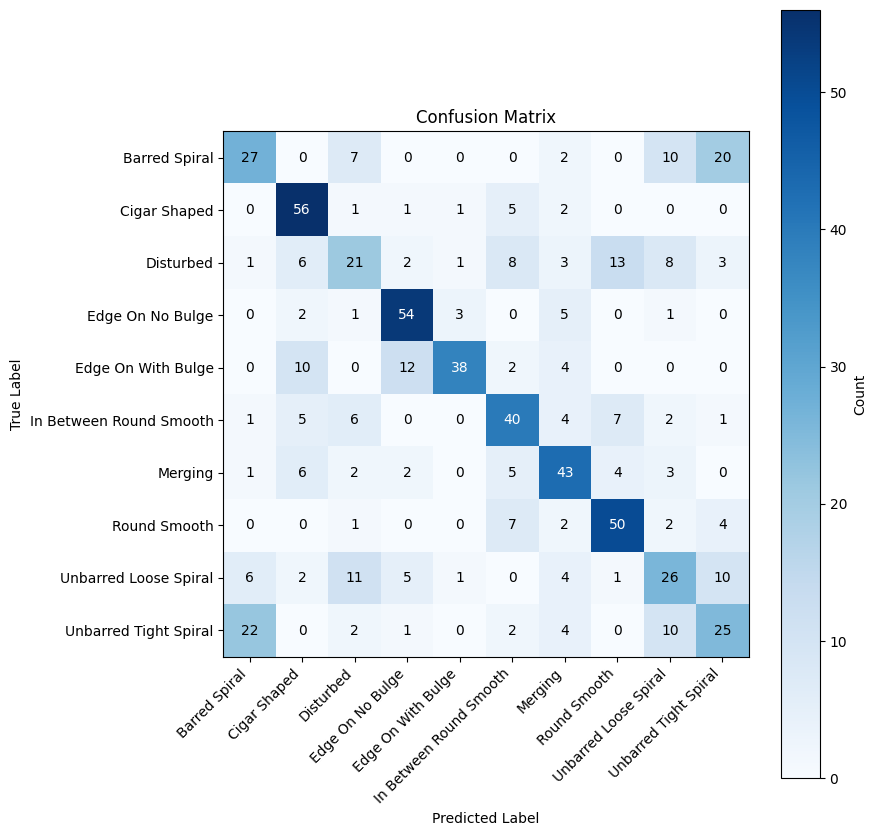

In [ ]:
plot_confusion_matrix(labels=balanced_test_results["labels"],
                                  predictions=balanced_test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>

#### Evaluating on unbalanced test dataset

In [ ]:
test_results = test_model(model=custom_model,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5643
Test loss : 1.2276


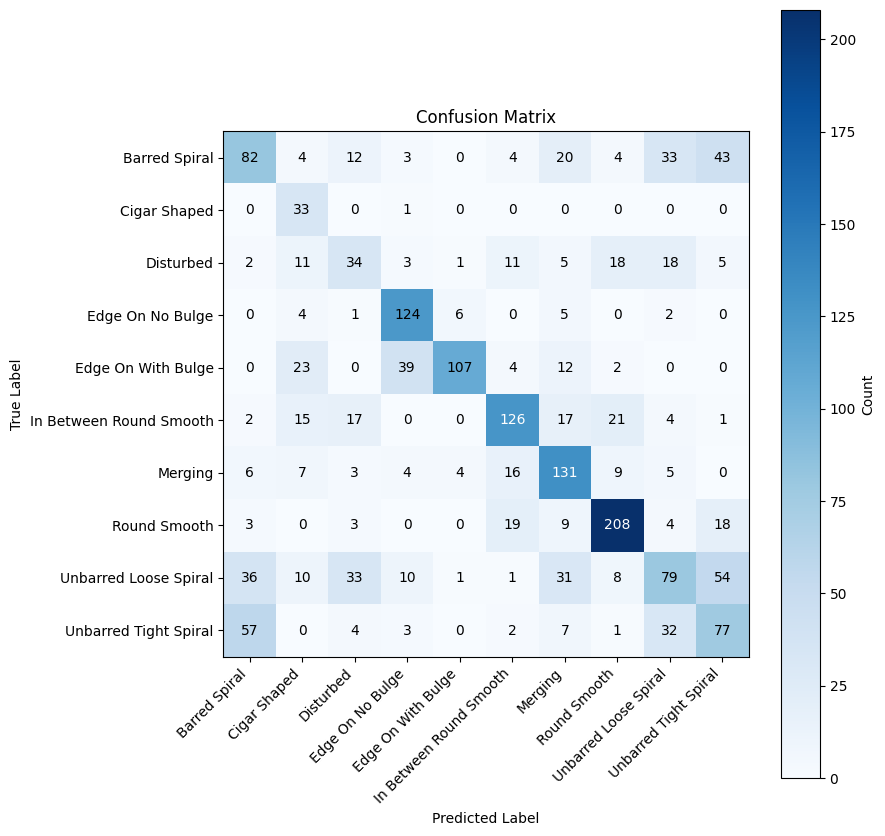

In [ ]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>
<br>
<br>

## ViT